In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/ekaramustafa/diffposenet.git

Cloning into 'diffposenet'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 259 (delta 48), reused 0 (delta 0), pack-reused 178 (from 1)
Receiving objects: 100% (259/259), 117.13 KiB | 4.50 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [4]:
%cd /content/diffposenet/

/content/diffposenet


Initial Test Loss (Before Training): 38.2361


Epoch [1/10]: 100%|██████████| 65/65 [04:13<00:00,  3.89s/it, Batch Loss=49.6]


Epoch [1/10], Avg Train Loss: 33.3614
Epoch [1/10], Test Loss: 34.2517


Epoch [2/10]: 100%|██████████| 65/65 [00:21<00:00,  3.04it/s, Batch Loss=9.69]


Epoch [2/10], Avg Train Loss: 29.7181
Epoch [2/10], Test Loss: 32.4692


Epoch [3/10]: 100%|██████████| 65/65 [00:21<00:00,  3.04it/s, Batch Loss=26.1]


Epoch [3/10], Avg Train Loss: 28.2245
Epoch [3/10], Test Loss: 29.1161


Epoch [4/10]: 100%|██████████| 65/65 [00:21<00:00,  3.06it/s, Batch Loss=30.7]


Epoch [4/10], Avg Train Loss: 26.4835
Epoch [4/10], Test Loss: 27.5670


Epoch [5/10]: 100%|██████████| 65/65 [00:21<00:00,  3.04it/s, Batch Loss=10.5]


Epoch [5/10], Avg Train Loss: 24.1185
Epoch [5/10], Test Loss: 24.5750


Epoch [6/10]: 100%|██████████| 65/65 [00:21<00:00,  3.02it/s, Batch Loss=17.4]


Epoch [6/10], Avg Train Loss: 23.7286
Epoch [6/10], Test Loss: 23.6384


Epoch [7/10]: 100%|██████████| 65/65 [00:21<00:00,  3.03it/s, Batch Loss=24.5]


Epoch [7/10], Avg Train Loss: 22.9232
Epoch [7/10], Test Loss: 22.9331


Epoch [8/10]: 100%|██████████| 65/65 [00:21<00:00,  3.06it/s, Batch Loss=31.1]


Epoch [8/10], Avg Train Loss: 22.7326
Epoch [8/10], Test Loss: 23.4337


Epoch [9/10]: 100%|██████████| 65/65 [00:21<00:00,  3.05it/s, Batch Loss=14.5]


Epoch [9/10], Avg Train Loss: 23.3564
Epoch [9/10], Test Loss: 23.6683


Epoch [10/10]: 100%|██████████| 65/65 [00:21<00:00,  3.03it/s, Batch Loss=9.35]


Epoch [10/10], Avg Train Loss: 21.8829
Epoch [10/10], Test Loss: 22.8921


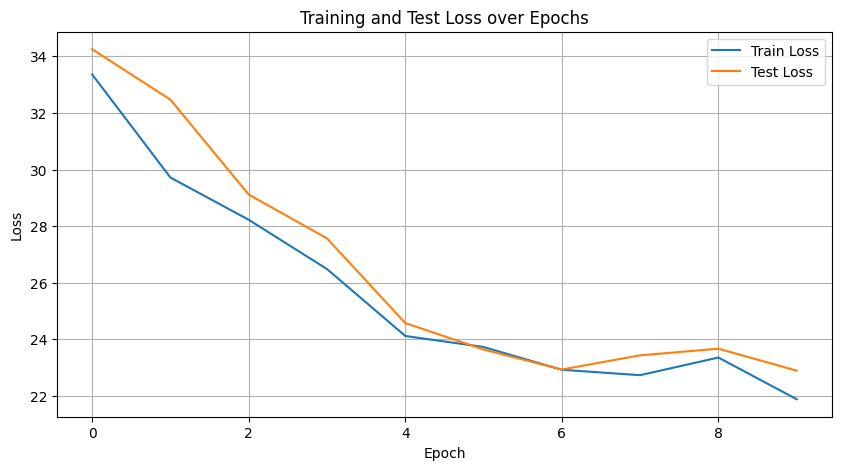

In [5]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from tqdm import tqdm
import numpy as np
from PIL import Image
import glob


from nflownet.model import NFlowNet
from dataset.tartanair2 import PairedImageDataset


img_file_path = '/content/drive/My Drive/P008/image_left'
opt_flow_file_path = '/content/drive/My Drive/P008/flow'

dataset = PairedImageDataset(img_file_path, opt_flow_file_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_file_path = '/content/drive/My Drive/P008/image_left'
opt_flow_file_path = '/content/drive/My Drive/P008/flow'
dataset = PairedImageDataset(img_file_path, opt_flow_file_path)

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = NFlowNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_losses = []
test_losses = []

# ----- Compute Initial Loss (Before any training) -----
model.eval()
initial_test_loss = 0.0
with torch.no_grad():
    for paired_batch, normal_flow_batch in test_loader:
        paired_batch, normal_flow_batch = paired_batch.to(device), normal_flow_batch.to(device)
        outputs = model(paired_batch)

        loss = criterion(outputs, normal_flow_batch)
        initial_test_loss += loss.item()

initial_test_loss /= len(test_loader)
print(f"Initial Test Loss (Before Training): {initial_test_loss:.4f}")

# ----- Training Loop -----
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    batch_losses = []

    # Wrap train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

    for paired_batch, normal_flow_batch in pbar:
        paired_batch, normal_flow_batch = paired_batch.to(device), normal_flow_batch.to(device)

        optimizer.zero_grad()
        outputs = model(paired_batch)

        loss = criterion(outputs, normal_flow_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        batch_losses.append(loss.item())

        # Update progress bar with current batch loss
        pbar.set_postfix({'Batch Loss': loss.item()})

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}")

    # ----- Evaluate on Test Data -----
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for paired_batch, normal_flow_batch in test_loader:
            paired_batch, normal_flow_batch = paired_batch.to(device), normal_flow_batch.to(device)
            outputs = model(paired_batch)
            loss = criterion(outputs, normal_flow_batch)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

# ----- Plotting -----
plt.figure(figsize=(10,5))
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), test_losses, label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()